# Diffusion Models for Generative AI

Diffusion models are a class of generative models that create new data by reversing a process that gradually adds noise. They operate in two main phases:

- **Forward Process (Diffusion):** Noise is incrementally added to the original data over $T$ steps, transforming it into pure noise.
- **Model Training:** The model learns to predict the noise added at each step, enabling it to understand how to reverse the process.
- **Backward Process (Denoising):** Starting from random noise, the model iteratively removes noise over $T$ steps, reconstructing a new, realistic sample.

This approach allows diffusion models to generate new high-quality images from a image dataset by simulating the process of denoising.

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import mnist

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

mnist_train = mnist.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = mnist.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.55MB/s]


### Forward Process - Noising

Let $x_0$ be the image at t=0, and $x_t$ be the data at timestep $t$ after adding noise. The forward process is defined as:

$$x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, 1)$$

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \quad \beta_t \mathbf{I}),\quad t \sim \mathcal{N}(0, T)$$



where $\beta_t = 1 - \alpha_t$ is the variance schedule for timestep $t$.

The cumulative process from $x_0$ to $x_t$:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, \quad (1 - \bar{\alpha}_t) \mathbf{I})
$$

where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$.

#### Algorithm

1. **Initialize** $x_0$ as the original data sample.
2. **For** $t = 1$ to $T$:
    - Sample noise $\epsilon_t \sim \mathcal{N}(0, \mathbf{I})$
    - Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t$
3. **Return** $x_T$ as the fully noised data.

This process gradually transforms the original data into pure noise over $T$ steps.

In [3]:
T = 30  # total timesteps
a = 0.1 # noise proportion per step
# kept constant for simplicity
device = "cuda" if torch.cuda.is_available() else "cpu"

def Noising(images, T, a):
    t = torch.randint(0, T, (images.size(0),), device=images.device).float()
    noise = torch.randn_like(images)
    a_t = a**t

    noisy_images = (a_t.view(-1, 1, 1, 1))**0.5 * images + (1 - a_t).view(-1, 1, 1, 1)**0.5 * noise

    return noisy_images, noise , t  # -> this should also be output

### Deep Learning Model ###
A simple CNN based model to run over-the image reduse the dimensions and atlast give an output $\epsilon_t$.\
$\epsilon_t$ is a prediction of the amount of error introduced. And, the model learns to predict $\epsilon_t$ better and better.

## U-NET Model Architecture

This model is inspired by the **U-Net architecture**, with additional **time embeddings** to condition the network on the diffusion step `t`.

---

### Key Components
- **DoubleConv**: Two consecutive `Conv2d + ReLU` layers, used as the basic building block.  
- **Down (Encoder path)**: `MaxPool2d` for downsampling, followed by `DoubleConv`. Captures hierarchical features.  
- **Up (Decoder path)**: `Upsample` to increase spatial resolution, concatenates encoder features via skip connections, then applies `DoubleConv` to preserve fine details.  
- **OutConv**: Final `1×1 convolution` to reduce channels to match output image size.  
- **Time Embedding (`time_mlp`)**: Small MLP that processes the diffusion step `t` into an embedding, conditioning the model on the current timestep.

---

### Forward Pass
1. Input image `x` goes through the encoder:  
   `inc → down1 → down2 → down3 → down4`  
2. Decoder reconstructs the image with skip connections:  
   `up1(x5, x4) → up2(x, x3) → up3(x, x2) → up4(x, x1)`  
3. Final output produced with `OutConv`.  
4. Diffusion step `t` is embedded via `time_mlp` and conditions the model during training.

---

### Model Usage
- **Input**: noisy image `x` and diffusion step `t`  
- **Output**: predicted denoised image (same shape as `x`)  

This design makes the model suitable for **denoising diffusion probabilistic models (DDPMs)** and other generative tasks.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Diffusion(nn.Module):
    def __init__(self, img_channels=1, hidden_dim=64):
        super().__init__()
        self.inc = DoubleConv(img_channels, hidden_dim)
        self.down1 = Down(hidden_dim, hidden_dim * 2)
        self.down2 = Down(hidden_dim * 2, hidden_dim * 4)
        self.down3 = Down(hidden_dim * 4, hidden_dim * 8)
        self.down4 = Down(hidden_dim * 8, hidden_dim * 8)
        self.up1 = Up(hidden_dim * 16, hidden_dim * 4)
        self.up2 = Up(hidden_dim * 8, hidden_dim * 2)
        self.up3 = Up(hidden_dim * 4, hidden_dim)
        self.up4 = Up(hidden_dim * 2, hidden_dim)
        self.outc = OutConv(hidden_dim, img_channels)

        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x, t):
        t = t.view(-1, 1).float() / 1000.0  # scale down
        t_emb = self.time_mlp(t)[:, :, None, None]

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)

        return out

### Model Training
- Design a loss function to train for $\epsilon_t$.
- For simplicity MSELoss

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Diffusion().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

T = 30
a = 0.9 # decay factor

# Use DataLoader for efficient batching
batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        noisy_images, noise, t = Noising(images, T, a)

        noise_pred = model(noisy_images, t)

        loss = criterion(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)  # accumulate by batch size

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.1221
Epoch [2/20], Loss: 0.0762
Epoch [3/20], Loss: 0.0712
Epoch [4/20], Loss: 0.0693
Epoch [5/20], Loss: 0.0678
Epoch [6/20], Loss: 0.0677
Epoch [7/20], Loss: 0.0648
Epoch [8/20], Loss: 0.0641
Epoch [9/20], Loss: 0.0645
Epoch [10/20], Loss: 0.0632
Epoch [11/20], Loss: 0.0627
Epoch [12/20], Loss: 0.0635
Epoch [13/20], Loss: 0.0616
Epoch [14/20], Loss: 0.0604
Epoch [15/20], Loss: 0.0620
Epoch [16/20], Loss: 0.0616
Epoch [17/20], Loss: 0.0613
Epoch [18/20], Loss: 0.0608
Epoch [19/20], Loss: 0.0623
Epoch [20/20], Loss: 0.0606


**Full Update Rule:**

The full denoising update at each step is:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z
$$

where:
- $\alpha_t$: noise schedule at step $t$
- $\bar{\alpha}_t$: cumulative product of $\alpha_t$ up to $t$
- $\epsilon_\theta(x_t, t)$: predicted noise by the model
- $\sigma_t$: standard deviation for added noise
- $z \sim \mathcal{N}(0, I)$: random noise

This update produces higher fidelity samples by accounting for the variance schedule.


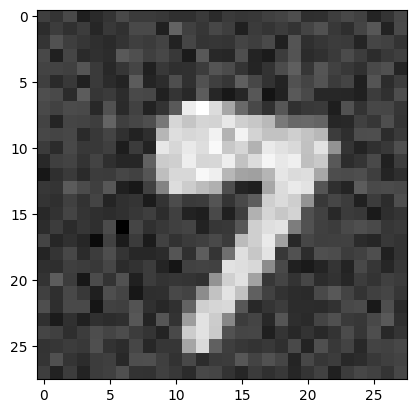

In [46]:
import torch

@torch.no_grad()
def Denoising(model, img_size=(1, 28, 28), T=30, device="cpu"):
    model.eval()
    betas = torch.linspace(1e-4, 0.02, T, device=device)
    alphas = 1.0 - betas
    alpha_bar = torch.cumprod(alphas, dim=0)

    # pure noise
    x_t = torch.randn(1, *img_size, device=device)

    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device, dtype=torch.long)

        # predict noise
        eps_theta = model(x_t, t_tensor)

        # coefficients
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bar[t]
        beta_t = betas[t]

        # mean term μ_θ(x_t, t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta
        )

        if t > 0:
            # variance term σ_t z
            alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0, device=device)
            posterior_var = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
            sigma_t = torch.sqrt(posterior_var)
            noise = torch.randn_like(x_t)
            x_t = mean + sigma_t * noise
        else:
            # at t=0, just take the mean
            x_t = mean

    return x_t


if __name__ == "__main__":
    gen_image = Denoising(model, img_size=(1, 28, 28), T=1000, device= device)
    import matplotlib.pyplot as plt
    plt.imshow(gen_image.squeeze().cpu(), cmap="gray")
    plt.show()